In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cebra import CEBRA
import cebra
import pickle
import torch
import cebra_datahelpers
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from scipy.stats import sem
from scipy.spatial import ConvexHull, distance
from scipy.optimize import leastsq
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import statsmodels.api as sm
from math import log

# Check for GPU availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Ensure reproducibility
np.random.seed(1)

Instructions

This code is used for the analysis of the Sucrose-Quinine electrophysiological data [CEBRA]. Demo data provided with the already electrophysiological data [SQ_extraction.ipynb] from 2 mice.

raw data: 'SQ_cebra_demodata_data.pkl'

Pre-trained model is provided to get the embeddings from the paper. 

In [2]:
def plot_embeddings(emb_list, lbeh_list, filename=None, elev=-12, azim=-95):
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(4, 3, figure=fig)
    
    ax = [fig.add_subplot(gs[i], projection='3d') for i in range(len(emb_list))]
    
    for i, (emb, lbeh) in enumerate(zip(emb_list, lbeh_list)):
        idx_pos = lbeh > 0
        idx_neg = lbeh < 0
        
        # Colors and scatter points
        scatter_pos = ax[i].scatter(
            emb[idx_pos, 1], emb[idx_pos, 2], emb[idx_pos, 0], 
            cmap="Greens", s=0.5, c=lbeh[idx_pos], alpha=0.7, vmin=199, vmax=201
        )
        scatter_neg = ax[i].scatter(
            emb[idx_neg, 1], emb[idx_neg, 2], emb[idx_neg, 0], 
            cmap="Oranges", s=0.5, c=lbeh[idx_neg], alpha=0.7, vmin=-201, vmax=-199
        )
    
    for a in ax:
        a.view_init(elev=elev, azim=azim)
        a.xaxis.pane.fill = False
        a.yaxis.pane.fill = False
        a.zaxis.pane.fill = False
        a.xaxis.pane.set_edgecolor('w')
        a.yaxis.pane.set_edgecolor('w')
        a.zaxis.pane.set_edgecolor('w')
        a.axis('off')
    
    # Remove unnecessary spaces
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    if filename:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    
    plt.show()

In [3]:
#preprocessed data of 2 mice[M2498,M2502]

with open("SQ_raw\SQ_cebra_demodata_data.pkl", 'rb') as f:
    l_data, l_beh, l_data_25, mousename_saline=pickle.load(f)

In [4]:
for i in range(len(l_beh)):
    l_data[i] = l_data[i].T
    l_beh[i] = l_beh[i].T
    l_data[i] = torch.from_numpy(l_data[i]).type(torch.FloatTensor)

In [5]:
l_data_shuffled = []
for i in range(len(l_data)):
    # Shuffle rows
    num_rows = l_data[i].size(0)
    row_perm = torch.randperm(num_rows)
    shuffled_data = l_data[i][row_perm]
    
    # Shuffle columns
    num_cols = shuffled_data.size(1)
    col_perm = torch.randperm(num_cols)
    shuffled_data = shuffled_data[:, col_perm]
    
    # Append the shuffled data to the new list
    l_data_shuffled.append(shuffled_data)

In [6]:
''' 
Define the model parameters here!
'''
def init_model_time(model_arch,max_iterations=10000, temp=1):
    return cebra.CEBRA(model_architecture=model_arch,
                        batch_size=512,
                        learning_rate=0.0003,
                        temperature=1.15,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        num_hidden_units=20,
                        verbose=True,
                        time_offsets=10)

In [16]:
iter = 10000

In [ ]:
#Train the model , No need to run the model again. Use the pretrained one 

#real
# model_pos_testtrain_saline = init_model_time('offset10-model',max_iterations=iter)
# model_pos_testtrain_saline.fit(l_data, l_beh)#change type here
# model_pos_testtrain_saline.save("Results/SQ/saline_model_time_iter"+str(iter)+"_real")

# embedding_pos_whole = [None]*len(l_beh)

# for i in range(len(l_beh)):
#     embedding_pos_whole[i] = model_pos_testtrain_saline.transform(l_data[i],i)#change type here

# # #shuffle
# model_pos_testtrain_saline_sh = init_model_time('offset10-model', max_iterations=iter)
# model_pos_testtrain_saline_sh.fit(l_data_shuffled  , l_beh)
# model_pos_testtrain_saline_sh.save("Results/SQ/saline_model_time_iter"+str(iter)+"_shuffle")
# # #added sh_old at the end
# embedding_pos_whole_sh = [None]*len(l_beh)
# for i in range(len(l_beh)):
#     embedding_pos_whole_sh[i] = model_pos_testtrain_saline_sh.transform(l_data_shuffled [i],i)


pos: -0.6227 neg:  7.2221 total:  6.5993 temperature:  1.1500: 100%|██████████| 10000/10000 [01:50<00:00, 90.20it/s]


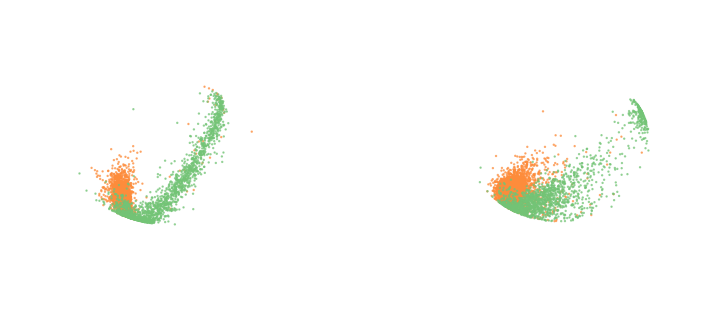

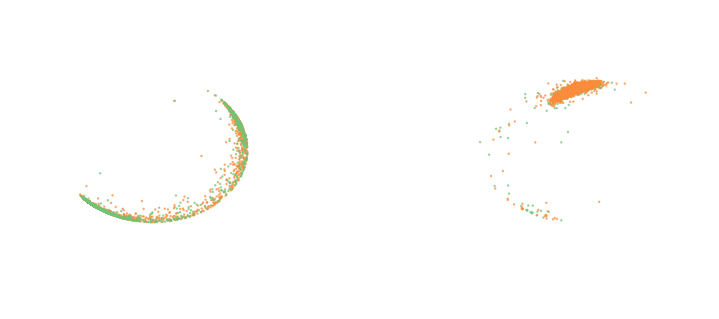

In [ ]:
#real 
embedding_pos_whole = []
l_beh_whole = []
# SHUFFLE
embedding_pos_whole_sh = []
l_beh_whole_sh = []

#for already trained model, use this 
mod = cebra.CEBRA.load("Results/SQ/SQ_model_temp1_not25mspermuteshuffle_time_3dim_20units_offset10_iter10000_lr_3eminus4_offset10_kilo_remove")
mod_sh = cebra.CEBRA.load("Results/SQ/SQ_model_temp1_not25mspermuteshuffle_time_3dim_20units_offset10_iter10000_lr_3eminus4_offset10_sh_kilo_remove")

mouse_idx = [8,9]
# Process the data
for i in range(len(l_data)):  
    embedding = mod.transform(l_data[i], mouse_idx[i])
    embedding_sh = mod_sh.transform(l_data_shuffled[i],mouse_idx[i])
    embedding_pos_whole.append(embedding)
    l_beh_whole.append(np.array(l_beh[i]))
    embedding_pos_whole_sh.append(embedding_sh)
    l_beh_whole_sh.append(np.array(l_beh[i]))

# Plot the shuffled embeddings / change the NAME
plot_embeddings(
    embedding_pos_whole[:len(l_data)], 
    l_beh_whole[:len(l_data)], filename=False,
    elev=24, azim=88,
)
# for shuffle 
plot_embeddings(
    embedding_pos_whole_sh[:len(l_data)], 
    l_beh_whole_sh[:len(l_data)], filename=False,
    elev=24, azim=88, 
)

In [9]:
# Decoder
def add_class(beh):
    classvar = []#np.zeros(np.array(beh).shape[0])
    idx = []
    for i in range(beh.shape[0]):
        if beh[i] == 200:  
            classvar.append(1)
            idx.append(i)
          
        elif beh[i]==-200:
            classvar.append(0)
            idx.append(i)
        else:
            continue
    #beh = np.array(beh)
    #beh_new = np.vstack((beh.T, classvar)).T

    return np.array(classvar), idx

def classifier(emb_train, emb_test, beh_train, beh_test,n_neighbors=100):
    decoder = KNeighborsClassifier(n_neighbors=n_neighbors) #svm.SVC()
    decoder.fit(emb_train, beh_train)
    score_train = decoder.score(X=emb_train, y=beh_train)
    score = decoder.score(X=emb_test, y=beh_test)
    return score_train, score#, accuracy


In [10]:
#real data
score_train_saline, score_saline = [None]*len(l_beh), [None]*len(l_beh)

time_S_saline = []
time_Q_saline = []
time_all_saline = []
time_all_centre_saline = []

for i in range(len(l_beh)):
    beh, idx = add_class(l_beh[i][:])
    time_S_saline.append(np.sum(1*np.array(l_beh[i] == 200)))
    time_Q_saline.append(np.sum(1*np.array(l_beh[i] == -200)))
    time_all_saline.append(time_S_saline[i] + time_Q_saline[i])
    time_all_centre_saline.append((l_beh[i].size))

    emb = embedding_pos_whole[i][idx, :] #change here embedding_pos_whole_saline, l_beh(same for saline)
    emb_train, emb_test, l_beh_lowdim_train, l_beh_lowdim_test = train_test_split(emb, beh)
    score_train_saline[i], score_saline[i]=classifier(emb_train, emb_test, l_beh_lowdim_train,l_beh_lowdim_test)

S_frac_saline = np.array(time_S_saline)/np.array(time_all_saline)
Q_frac_saline = np.array(time_Q_saline)/np.array(time_all_saline)

score_saline = np.array(score_saline)
closed_arm_frac_saline = np.zeros(len(l_beh))#change beh here too 


for i in range(len(l_beh)):
    if S_frac_saline[i]>=Q_frac_saline[i]:
        closed_arm_frac_saline[i] = S_frac_saline[i]
    else:
        closed_arm_frac_saline[i] = Q_frac_saline[i]

normalised_real_saline = score_saline * 0.5/closed_arm_frac_saline

In [ ]:
#shuffle
score_train_saline_sh, score_saline_sh = [None]*len(l_beh), [None]*len(l_beh)
for i in range(len(l_beh)):
    beh, idx = add_class(l_beh[i][:])
    time_S_saline.append(np.sum(1*np.array(l_beh[i] == 200)))
    time_Q_saline.append(np.sum(1*np.array(l_beh[i] == -200)))
    time_all_saline.append(time_S_saline[i] + time_Q_saline[i])
    time_all_centre_saline.append((l_beh[i].size))

    emb = embedding_pos_whole_sh[i][idx, :] #change here embedding_pos_whole_saline, l_beh(same for saline)
    emb_train, emb_test, l_beh_lowdim_train, l_beh_lowdim_test = train_test_split(emb, beh)
    score_train_saline_sh[i], score_saline_sh[i]=classifier(emb_train, emb_test, l_beh_lowdim_train,l_beh_lowdim_test)

S_frac_saline_sh = np.array(time_S_saline)/np.array(time_all_saline)
Q_frac_saline_sh = np.array(time_Q_saline)/np.array(time_all_saline)
score_saline_sh = np.array(score_saline_sh)

closed_arm_frac_saline_sh = np.zeros(len(l_beh))#change beh here too 
for i in range(len(l_beh)):
    if S_frac_saline_sh[i]>=Q_frac_saline_sh[i]:
        closed_arm_frac_saline_sh[i] = S_frac_saline_sh[i]
    else:
        closed_arm_frac_saline_sh[i] = Q_frac_saline_sh[i]
normalised_real_saline_sh = score_saline_sh * 0.5/closed_arm_frac_saline_sh

Text(0.5, 1.0, 'SQ Decoding, normalised')

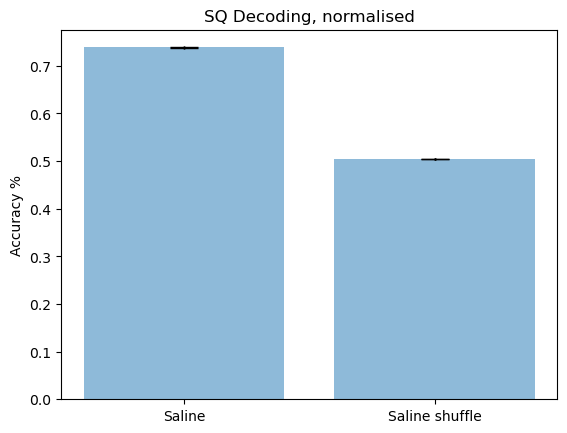

In [ ]:
#This is the decoding accuracy: Fig 5i
from scipy.stats import sem

mean_real = np.mean(normalised_real_saline)
mean_sh = np.mean(normalised_real_saline_sh)
sem_real = sem(normalised_real_saline)
sem_sh = sem(normalised_real_saline_sh)
plt.bar([0,1], [mean_real, mean_sh], yerr=[sem_real, sem_sh], alpha=0.5,align='center', ecolor='black', capsize=10,)
plt.scatter(np.zeros(len(l_beh)), normalised_real_saline, c='k', s=0.5)
plt.scatter(np.ones(len(l_beh)), normalised_real_saline_sh, c='k', s=0.5)#change beh name
plt.ylabel('Accuracy %')
plt.xticks([0,1], ['Saline', 'Saline shuffle'])
plt.title('SQ Decoding, normalised')


Barycenter analysis related to Fig 6o

In [ ]:
def clusterAnalysis(emb, beh):

    dist = []
    idx_beh_pos = beh>0

    idx_beh_neg = beh<0
    emb_pos = np.average(emb[idx_beh_pos, :], axis=0)
    emb_neg = np.average(emb[idx_beh_neg, :], axis=0)
    dist = np.linalg.norm(emb_pos-emb_neg)
    return dist, emb[idx_beh_pos, :],emb[idx_beh_neg, :], emb_pos, emb_neg

In [ ]:
dist_saline =np.zeros(len(l_beh))
dist_saline_sh =np.zeros(len(l_beh))
emb_pos_saline, emb_neg_saline = [None]*len(embedding_pos_whole), [None]*len(embedding_pos_whole)
emb_pos_saline_sh, emb_neg_saline_sh = [None]*len(embedding_pos_whole_sh), [None]*len(embedding_pos_whole_sh)
emb_pos , emb_neg = [None]*len(embedding_pos_whole), [None]*len(embedding_pos_whole)
emb_pos_sh , emb_neg_sh = [None]*len(embedding_pos_whole_sh), [None]*len(embedding_pos_whole_sh)

for i in range(len(l_beh)):
    dist_saline_sh[i],emb_pos_saline_sh[i], emb_neg_saline_sh[i], emb_pos_sh[i], emb_neg_sh[i] = clusterAnalysis(embedding_pos_whole_sh[i], l_beh[i])

for i in range(len(l_beh)):
    # print(i)
    dist_saline[i],emb_pos_saline[i], emb_neg_saline[i], emb_pos[i], emb_neg[i] = clusterAnalysis(embedding_pos_whole[i], l_beh[i])
	

In [20]:
dist_saline = np.array(dist_saline)
dist_saline_sh = np.array(dist_saline_sh)